## Answer questions

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import pandas as pd
from src.paths import TRANSFORMED_DATA_DIR, MODELS_DIR, RAW_DATA_DIR

In [50]:
# Read metadata json file from models folder
import json

metadata = json.load(open(MODELS_DIR / 'metadata.json'))

In [51]:
print(f'Model being used is: {metadata["name"]}')

Model being used is: XGBoost with trees tuned with RandomizedSearchCV with less features


In [52]:
if metadata['name'] == 'Linear regression model':
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data_for_lr.csv')
    data_no_dummies = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')
else:
    data = pd.read_csv(TRANSFORMED_DATA_DIR / 'transformed_data.csv')

In [53]:
data.shape

(4817, 23)

In [54]:
# Convert date columns to datetime
data['registration_date'] = pd.to_datetime(data['registration_date'])
data['sold_at'] = pd.to_datetime(data['sold_at'])

In [55]:
# Change data types from object to categorical
from src.data import convert_object_columns_to_category

data = convert_object_columns_to_category(data)

In [56]:
from src.data import get_train_test_data

In [57]:
features = metadata['features']
target = metadata['target']

In [58]:
# Print the features
features

['mileage',
 'engine_power',
 'fuel',
 'paint_color',
 'car_type',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'age_in_months_when_sold',
 'month_sold_at',
 'season_sold_at',
 'model_initial',
 'mileage_per_month']

In [59]:
X, y, X_train, X_test, y_train, y_test = get_train_test_data(data, features, target)

In [60]:
import joblib

In [61]:
# Load the model
model = joblib.load(MODELS_DIR / 'model.pkl')

In [62]:
# Print the model
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=6, max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Q1

In [63]:
# Read feature importance df from models folder
feature_importance = joblib.load(MODELS_DIR / 'feature_importance_df.pkl')

In [64]:
# In the case of linear regression these are the coefficients
feature_importance

,feature,importance
1,engine_power,0.299028
12,feature_8,0.155326
13,age_in_months_when_sold,0.108049
16,model_initial,0.106577
0,mileage,0.061572
9,feature_5,0.046123
5,feature_1,0.029129
8,feature_4,0.029017
3,paint_color,0.025644
11,feature_7,0.024875


In [65]:
from src.questions import get_linear_regression_p_values, get_linear_regression_f_test_results

In [66]:
if metadata['name'] == 'Linear regression model':
    coef_p_values_df = get_linear_regression_p_values(X, y, model)
    f_stat, f_test_p_val = get_linear_regression_f_test_results(X, y, model)
else:
    coef_p_values_df = None
    f_stat, f_test_p_val = None, None

In [67]:
coef_p_values_df

In [68]:
print(f'F-statistic: {f_stat}')
print(f'F-test p-value: {f_test_p_val}')

F-statistic: None
F-test p-value: None


In [69]:
from src.plots import plot_shap_summary

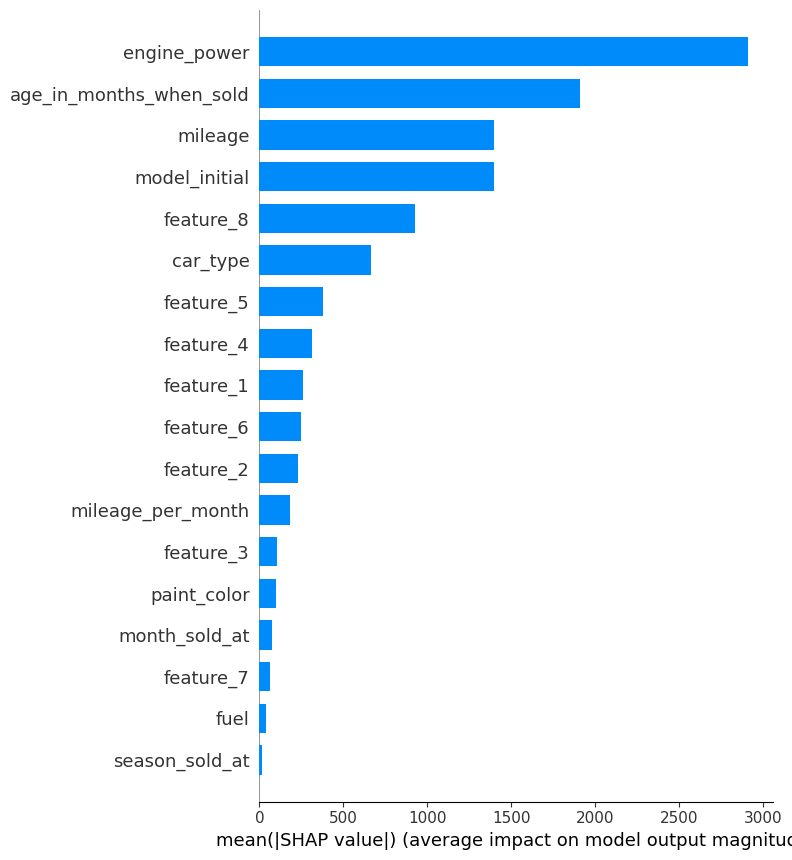

In [70]:
explainer = plot_shap_summary(metadata, model, X)

### Q2

As found during the data exploration phase:
- Except for feature_7, cars with True in the other car features have in average higher prices than cars without them. This suggests that these features will be important for predictive models.
- There seems to be a peak average price in Aug 2018. This may be caused by a sale of a highly price car precisely this month.
- Hybrid and electrical cars are more expensive on average.
- Electrical cars average prices were stable from winter to summer, and were not sold in autumn.
- Diesel and petrol cars had similar average prices, although petrol cars had a drop in average prices starting summer 2018.
- The most expensive car type is, on average, suv, although coupe was most expensive at the start of the year and then dropped below suv also starting in summer.
- Coupe and convertible cars were, on average, more expensive in winter than in summer.
- Vans where more expensive, on average, in spring, summer, and autumn, than in winter.
- Subcompact had generally the lowest average prices.
- Paint color does not seem to generally determine or be associated with the average price, except for color green, which consistently had prices much lower than other colors. Maybe not very popular.
- Orange and white cars were sold for more, on average, during summer than during winter and spring.
- Red cars were the opposite, with lower average prices during summer than during winter and spring.

Find similar observations using estimated price instead of real price

In [71]:
pred = model.predict(X)

In [72]:
if metadata['name'] == 'Linear regression model':
    data_q2 = data_no_dummies.copy()
else:
    data_q2 = data.copy()

In [73]:
data_q2['price'] = pred

In [74]:
from src.plots import plot_avg_target_time_series_by_features

In [75]:
# Load car features
car_features = joblib.load(RAW_DATA_DIR / 'car_features.pkl')

In [76]:
plot_avg_target_time_series_by_features(data_q2, car_features)

In [77]:
# Load small cardinality features
small_cardinality_features = joblib.load(RAW_DATA_DIR / 'small_cardinality_features.pkl')

In [78]:
plot_avg_target_time_series_by_features(data_q2, small_cardinality_features)

In [79]:
from src.questions import make_ttest_results_df

In [80]:
grouping_column = 'season_sold_at'
group_1 = 'winter'
group_2 = 'summer'
ttest_df = make_ttest_results_df(data_q2, small_cardinality_features, grouping_column, group_1, group_2)

In [81]:
ttest_df.sort_values(by='p_val')

,feature,feature_value,t_stat,p_val
8,car_type,sedan,4.250434,0.000025
5,car_type,coupe,3.545226,0.000978
6,car_type,estate,2.770291,0.005739
14,paint_color,white,-2.264853,0.024339
11,car_type,van,-2.343723,0.031505
1,fuel,petrol,2.161624,0.033926
12,paint_color,black,1.172308,0.241420
4,car_type,convertible,1.131610,0.271185
15,paint_color,red,1.106760,0.278934
17,paint_color,blue,-1.038048,0.299996


### Q3

In [82]:
today_date = '3/1/2024'

In [83]:
data_q3 = data.copy()

In [84]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [85]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [86]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [87]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2024-03-01,145,286754.859155
1,2016-04-01,2024-03-01,95,60147.954545
2,2012-04-01,2024-03-01,143,374449.585714
3,2014-07-01,2024-03-01,116,345396.744186
4,2014-12-01,2024-03-01,111,269444.175000


In [88]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [89]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [90]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [91]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [92]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [93]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [94]:
price_today_threshold = 20000
loss_threshold = 2000

In [95]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [96]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_7,feature_8,age_in_months_when_sold,month_sold_at,season_sold_at,model_initial,mileage_per_month,price_today,price_one_year_later,loss
4615,103518.040816,180,diesel,black,suv,True,True,False,True,True,...,True,True,128,8,summer,X,808.734694,22048.496094,28737.001953,-6688.505859
90,50526.666667,170,hybrid_petrol,grey,coupe,True,True,False,False,False,...,False,True,110,4,spring,i,459.333333,43691.484375,44455.417969,-763.933594
67,66996.268657,309,petrol,silver,coupe,True,True,False,False,True,...,True,True,150,4,spring,M,446.641791,32884.460938,33061.554688,-177.093750
113,64433.400000,142,diesel,grey,coupe,True,True,False,False,True,...,True,True,102,5,spring,4,631.700000,22258.537109,22284.898438,-26.361328
3910,9278.857143,155,diesel,black,suv,True,True,False,True,True,...,True,True,92,2,winter,X,100.857143,27066.310547,26699.488281,366.822266
3964,68016.000000,155,diesel,grey,suv,True,True,False,True,True,...,True,True,112,3,spring,X,607.285714,23859.287109,23416.474609,442.812500
3908,128850.918919,230,diesel,red,suv,False,False,False,False,False,...,False,True,116,8,summer,X,1110.783784,20970.396484,20498.634766,471.761719
60,85229.783784,225,petrol,blue,coupe,True,True,False,True,True,...,True,True,121,3,spring,4,704.378378,21275.673828,20787.816406,487.857422
4126,85108.604651,230,diesel,silver,suv,False,False,False,False,False,...,False,True,126,4,spring,X,675.465116,22522.091797,22029.097656,492.994141
4717,165463.027027,230,diesel,grey,suv,True,True,False,True,False,...,True,True,116,8,summer,X,1426.405405,23528.658203,22870.132812,658.525391


In [97]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    model_related_value_counts = None
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()
    model_related_value_counts

In [98]:
model_related_value_counts

model_initial
X    14
4     5
M     4
5     1
7     1
i     1
1     0
2     0
3     0
6     0
A     0
Z     0
Name: count, dtype: int64

In [99]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,month_sold_at,mileage_per_month,price_today,price_one_year_later,loss
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,112529.792905,219.615385,118.153846,5.000000,945.809298,23976.751953,23348.718750,628.031982
std,50933.685975,49.211443,12.121691,2.332381,423.625219,4936.011719,5491.458008,1643.461792
min,9278.857143,142.000000,92.000000,1.000000,100.857143,20216.535156,19114.023438,-6688.505859
25%,67251.201493,182.500000,112.000000,3.000000,613.389286,21293.927246,20530.334961,475.785645
50%,116184.479868,230.000000,117.000000,4.000000,961.572447,22370.793945,21519.755859,835.644531
75%,152467.426592,230.000000,125.750000,7.750000,1310.217949,23994.745605,23279.889160,1496.082520
max,193735.400000,317.000000,150.000000,9.000000,1628.028571,43691.484375,44455.417969,1987.367188


In [100]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                                  BMW
model_key                                   X6
mileage                            93813.22449
engine_power                               180
registration_date          2014-07-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                   suv
feature_1                                 True
feature_2                                 True
feature_3                                False
feature_4                                 True
feature_5                                 True
feature_6                                False
feature_7                                 True
feature_8                                 True
price                                    43600
sold_at                    2024-03-01 00:00:00
age_in_months_when_sold                    116
month_sold_at                                8
season_sold_at                          summer
model_initial

In [101]:
data.loc[car_index]

maker_key                                  BMW
model_key                                   X6
mileage                                  39628
engine_power                               180
registration_date          2014-07-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                   suv
feature_1                                 True
feature_2                                 True
feature_3                                False
feature_4                                 True
feature_5                                 True
feature_6                                False
feature_7                                 True
feature_8                                 True
price                                    43600
sold_at                    2018-08-01 00:00:00
age_in_months_when_sold                     49
month_sold_at                                8
season_sold_at                          summer
model_initial

In [102]:
X_q3.loc[car_index]

mileage                    103518.040816
engine_power                         180
fuel                              diesel
paint_color                        black
car_type                             suv
feature_1                           True
feature_2                           True
feature_3                          False
feature_4                           True
feature_5                           True
feature_6                          False
feature_7                           True
feature_8                           True
age_in_months_when_sold              128
month_sold_at                          8
season_sold_at                    summer
model_initial                          X
mileage_per_month             808.734694
price_today                 22048.496094
price_one_year_later        28737.001953
loss                        -6688.505859
Name: 4615, dtype: object

In [103]:
# Check cars with the same model_key
if metadata['name'] == 'Linear regression model':
    cars_same_model_key = data_no_dummies[data_no_dummies['model_key'] == data_no_dummies['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
else:
    cars_same_model_key = data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
    
cars_same_model_key

,model_key,price,mileage,age_in_months_when_sold
4723,X6,66600,29460,32
4487,X6,62500,35025,27
4595,X6,61200,10955,25
4717,X6,60700,52777,37
4210,X6,59300,47417,22
4106,X6,55500,46041,31
4115,X6,55300,42318,29
4420,X6,50000,110556,38
4431,X6,45300,100512,53
4615,X6,43600,39628,49


Explain individual prediction with SHAP

In [104]:
X_q3_for_shap = X_q3[X.columns]

In [105]:
from src.plots import plot_shap_waterfall_for_car_sample

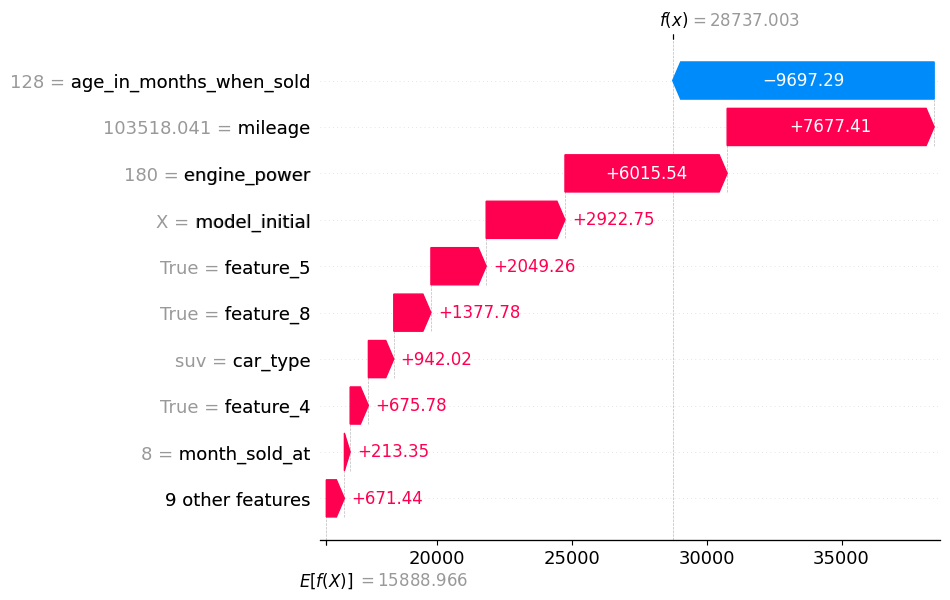

In [106]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

### Q3 assumming today is a month after latest sold at date in the data

In [142]:
today_date = data['sold_at'].max()

In [143]:
data_q3 = data.copy()

In [144]:
# Convert date columns to datetime and mock the sold_at date as today's date
data_q3['registration_date'] = pd.to_datetime(data_q3['registration_date'])
data_q3['sold_at'] = today_date
data_q3['sold_at'] = pd.to_datetime(data_q3['sold_at'])

In [145]:
# Calculate mileage per month
data_q3['mileage_per_month'] = data_q3['mileage'] / data_q3['age_in_months_when_sold']

In [146]:
# Calculate age in month at today date and replace in data_q3
data_q3['age_in_months_when_sold'] = (data_q3['sold_at'].dt.to_period('M') - data_q3['registration_date'].dt.to_period('M')).apply(lambda x: x.n)

In [147]:
# Update estimated mileage at today date
data_q3['mileage'] = data_q3['age_in_months_when_sold'] * data_q3['mileage_per_month']

In [148]:
data_q3[['registration_date', 'sold_at', 'age_in_months_when_sold', 'mileage']].head()

,registration_date,sold_at,age_in_months_when_sold,mileage
0,2012-02-01,2018-09-01,79,156231.957746
1,2016-04-01,2018-09-01,29,18360.954545
2,2012-04-01,2018-09-01,77,201626.700000
3,2014-07-01,2018-09-01,50,148877.906977
4,2014-12-01,2018-09-01,45,109234.125000


In [149]:
X_q3, y_q3, X_train_q3, X_test_q3, y_train_q3, y_test_q3 = get_train_test_data(data_q3, features, target)

In [150]:
# Get estimated prices today
pred_q3 = model.predict(X_q3)

In [151]:
# Add 1 year to the age_in_months_when_sold
X_q3['age_in_months_when_sold'] = X_q3['age_in_months_when_sold'] + 12

In [152]:
# Add 1 year worth of mileage
X_q3['mileage'] = X_q3['mileage'] + 12 * data_q3['mileage_per_month']

In [153]:
# Get estimated prices 1 year later
pred_q3_one_year_later = model.predict(X_q3)

In [154]:
X_q3['price_today'] = pred_q3
X_q3['price_one_year_later'] = pred_q3_one_year_later
X_q3['loss'] = X_q3['price_today'] - X_q3['price_one_year_later'] 

In [155]:
# Indentify cars that are candidates for buying
candidate_cars = X_q3[(X_q3['price_today'] >= price_today_threshold) & (X_q3['loss'] <= loss_threshold)]

In [156]:
# Show top 10 candidate cars with lowest loss
candidate_cars.sort_values('loss').head(10)

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_7,feature_8,age_in_months_when_sold,month_sold_at,season_sold_at,model_initial,mileage_per_month,price_today,price_one_year_later,loss
53,73034.280000,135,diesel,black,coupe,False,False,False,False,False,...,False,False,66,5,spring,4,1106.580000,20812.207031,41680.964844,-20868.757812
4206,70661.872340,120,diesel,grey,suv,True,True,False,True,False,...,True,True,63,5,spring,X,1121.617021,22814.662109,43152.394531,-20337.732422
4499,103077.391304,140,diesel,grey,suv,True,True,True,True,True,...,True,True,60,7,summer,X,1717.956522,30664.601562,42970.011719,-12305.410156
123,60717.800000,120,diesel,blue,coupe,True,True,False,False,True,...,True,True,65,6,summer,4,934.120000,25060.285156,30840.595703,-5780.310547
131,61018.431373,120,diesel,blue,coupe,True,True,False,False,True,...,True,True,65,7,summer,4,938.745098,25279.667969,30840.595703,-5560.927734
4462,109481.944444,230,diesel,blue,suv,True,True,False,False,True,...,True,True,50,7,summer,X,2189.638889,27561.185547,32712.613281,-5151.427734
4663,74819.684211,190,diesel,blue,suv,True,True,False,False,True,...,True,True,51,8,summer,X,1467.052632,30060.029297,33002.507812,-2942.478516
48,66621.020408,135,diesel,grey,coupe,False,False,False,False,False,...,False,True,65,5,spring,4,1024.938776,24995.451172,27003.792969,-2008.341797
583,32955.200000,140,diesel,black,estate,True,True,False,False,True,...,True,True,32,9,autumn,5,1029.850000,21858.335938,23860.041016,-2001.705078
1054,40706.000000,140,diesel,black,estate,True,True,False,False,True,...,True,True,32,5,spring,5,1272.062500,22241.511719,24243.216797,-2001.705078


In [157]:
# Find the value counts for model_key in candidate_cars if exists. If not try model key initial.
if metadata['name'] == 'Linear regression model':
    model_related_value_counts = None
else:
    try:
        model_related_value_counts = candidate_cars['model_key'].value_counts()
    except KeyError:
        model_related_value_counts = candidate_cars['model_initial'].value_counts()
    model_related_value_counts

In [158]:
model_related_value_counts

model_initial
X    67
5    47
4    35
6    11
7    10
3     9
M     8
2     7
i     3
A     1
1     0
Z     0
Name: count, dtype: int64

In [159]:
# Describe numerical features of candidate cars
candidate_cars.describe()

,mileage,engine_power,age_in_months_when_sold,month_sold_at,mileage_per_month,price_today,price_one_year_later,loss
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,102540.480883,164.535354,62.348485,5.095960,1625.999220,24955.287109,24434.162109,521.125488
std,63246.462617,44.194382,16.965919,2.058999,937.066950,4511.101562,5296.670410,2630.324219
min,597.333333,75.000000,26.000000,1.000000,9.333333,20023.099609,18304.503906,-20868.757812
25%,58484.777890,135.000000,48.000000,4.000000,1029.874679,21803.654785,20437.443359,365.609863
50%,91339.033878,140.000000,63.000000,5.000000,1478.380418,23618.064453,23178.381836,1172.206055
75%,134465.429487,190.000000,76.000000,7.000000,1953.377140,27127.907715,26823.279785,1573.607910
max,327917.692308,280.000000,95.000000,9.000000,5762.903226,40519.000000,43152.394531,1990.205078


In [160]:
# Show the car with the lowest loss
car_index = candidate_cars.sort_values('loss').index[0]
data_q3.loc[car_index]

maker_key                                  BMW
model_key                                  420
mileage                               59755.32
engine_power                               135
registration_date          2014-03-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                 coupe
feature_1                                False
feature_2                                False
feature_3                                False
feature_4                                False
feature_5                                False
feature_6                                False
feature_7                                False
feature_8                                False
price                                    26500
sold_at                    2018-09-01 00:00:00
age_in_months_when_sold                     54
month_sold_at                                5
season_sold_at                          spring
model_initial

In [161]:
data.loc[car_index]

maker_key                                  BMW
model_key                                  420
mileage                                  55329
engine_power                               135
registration_date          2014-03-01 00:00:00
fuel                                    diesel
paint_color                              black
car_type                                 coupe
feature_1                                False
feature_2                                False
feature_3                                False
feature_4                                False
feature_5                                False
feature_6                                False
feature_7                                False
feature_8                                False
price                                    26500
sold_at                    2018-05-01 00:00:00
age_in_months_when_sold                     50
month_sold_at                                5
season_sold_at                          spring
model_initial

In [162]:
X_q3.loc[car_index]

mileage                        73034.28
engine_power                        135
fuel                             diesel
paint_color                       black
car_type                          coupe
feature_1                         False
feature_2                         False
feature_3                         False
feature_4                         False
feature_5                         False
feature_6                         False
feature_7                         False
feature_8                         False
age_in_months_when_sold              66
month_sold_at                         5
season_sold_at                   spring
model_initial                         4
mileage_per_month               1106.58
price_today                20812.207031
price_one_year_later       41680.964844
loss                      -20868.757812
Name: 53, dtype: object

In [163]:
# Check cars with the same model_key
if metadata['name'] == 'Linear regression model':
    cars_same_model_key = data_no_dummies[data_no_dummies['model_key'] == data_no_dummies['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
else:
    cars_same_model_key = data[data['model_key'] == data['model_key'].loc[car_index]].sort_values(
        'price', ascending=False)[['model_key', 'price', 'mileage', 'age_in_months_when_sold']]
    
cars_same_model_key

,model_key,price,mileage,age_in_months_when_sold
13,420,36300,77061,31
40,420,34300,36696,48
114,420,30700,47902,28
27,420,28700,65988,46
2999,420,28100,80142,48
105,420,28000,33947,49
54,420,27700,14041,26
64,420,27700,61300,35
119,420,27600,45299,30
33,420,27500,64832,50


Explain individual prediction with SHAP

In [164]:
X_q3_for_shap = X_q3[X.columns]

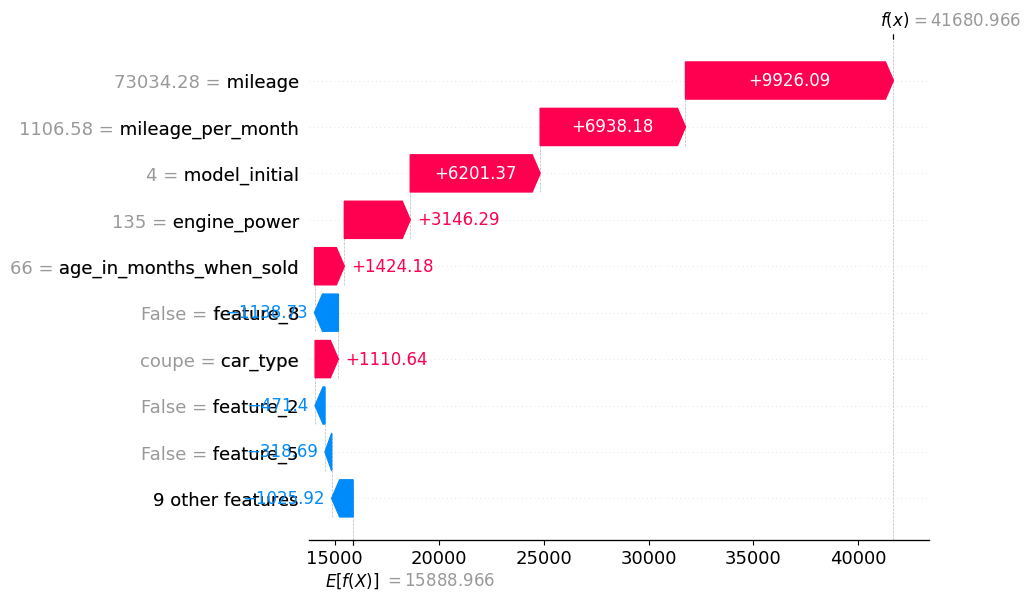

In [165]:
plot_shap_waterfall_for_car_sample(metadata, explainer, X_q3_for_shap, car_index)

### Q4

In [166]:
print(f'Test MSE: {metadata["mse_test"]:.2f}')
print(f'Test RMSE: {metadata["rmse_test"]:.2f}')
print(f'Test MAE: {metadata["mae_test"]:.2f}')
print(f'Test R2: {metadata["r2_test"]:.2f}')

Test MSE: 10468100.42
Test RMSE: 3235.44
Test MAE: 1917.73
Test R2: 0.84


### Q5

#### Data quality

There are no null values in the data.

There are no infinite values in the data.

There are no duplicates.

From the number of unique feature values we can observe that:
- There is only one maker (BWM). So, this feature will not give information to the models.
- There are 199 different registration dates.
- feature_1 to feature_8 are binary variables.
- The auction happened in 9 different dates.

Looking at the description of numerical features, hints that there are possibly erroneous observations. For example:
- a car with -64 miles,
- a car with 0 (I assume hp) engine power, 
- and a car that costed 100 (I assume USD)

Therefore, data needs some further cleaning.

There is a 640 Gran Coupé with negative mileage which is not possible. Also, there are other 18 cars of the same model key, so this row will be removed.

This is a 13 year-old car (159 months) with more than a million miles. Although strange, it is not impossible that it has driven this many miles (about 210 in average daily). So this observation is not recommended to be removed.

There is a wrong observation with 0 engine power for an X1 which is a SUV. This is impossible. Since there are more than 200 other X1 this observation can be removed.

Very likely the engine power of 25 (hp) for two i3 is wrong. These cars should have 75 (hp) engine power, so this is probably a typo. Since there are very few other i3 cars, data imputation might be a better alternative here to dropping the records. According to most values, a good candidate value for imputation is 75.

Regarding models 316 and 318, since there are more than 200 hundred other observations with the same model, and these cars typically have at least 75 of engine power, these records can also be deleted.

There were 62 cars sold at less than 1,000 which is very unusual. Looking at a description of the numerical features of these cars we find:
- The newest car sold at this price was less than 3 years old. This seems unusual.
- The oldest car was 24 years old.
- Minimum and max mileage seem sensible.

Prices below 800 seem more unusual and might correspond to cars with important damages. Since cars with engine damages were removed before, these other cars with important damages could be removed as well and maybe priced with another strategy.

#### Data distribution (after cleaning)

The features still have very high values after removing the data that probably had errors. 
Examples are:
- 1M miles drove. This can be rare but possible for old cars. 
- A few cars costed more than 100k, which is also possible depending on the car.
- There are some cars with engine power above 400, which can happen for sports cars.
- There are cars as old as 22 years, which is also possible.

These values do not suggest that further data cleaning is needed.

#### Numerical features vs. price

Based on the scatter plots, the following observations can be made:
- As expected, prices tend to decrease with mileage.
- As expected, prices tend to increase with engine power.
- As expected, prices tend to decrease with age.